In [9]:
import os
import sys
import time
import copy
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../')
from Utilities import *

In [10]:
# MS:  Management System
# ORR: Operating Reserve Rate
# SD:  Supply Distribution
# Equ: Equilibrium
# SUB: Subsidies
# SR:  Supply Ratio
# P/Q: Price/Quantity
# FSQ/FDQ: Fail supply/demand qunatity
# AD:  Anomaly Detection

In [11]:
IDS = 1                                # ID of Simulation
IDA = 1                                # ID of AD models
AType  = 0                             # Type of anomaly,   0->No, 1->Malicious, 2->MITM
AModel = 0                             # Type of AD models, 0->No, 1->CEE, 2->SDM
ADN    = ['No', 'CEE', 'SDM']          # Name of AD models
GType  = 2                             # Type of storage,   0->No, 1->NoSub, 2->Sub&Sort
OBJ_OR = 0.10                                        # Objective rate of operation reserve
OBJ_SD = [0.30, 0.10, 0.10, 0.15, 0.10, 0.10, 0.15]  # Objective supplier distribution

if AType==1:  PATHC, PATHP = 'Model/Malicious/', 'Model/Malicious/'
if AType==2:  PATHC, PATHP = 'Model/MITM/',      'Model/MITM/'
if AModel!=0: PATHC += ADN[AModel]+'-C_'+str(IDA)+'.pt'
if AModel!=0: PATHP += ADN[AModel]+'-P_'+str(IDA)+'.pt'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Simulation

In [12]:
random.seed(IDS)
Converge, Fail_Rate = np.zeros((N_Iter), dtype=float), np.zeros((N_Iter), dtype=float)     # Converge days, Fail rate
Mean_EQP, Var_EQP   = np.zeros((N_Iter), dtype=float), np.zeros((N_Iter), dtype=float)     # Mean & Variance of Equ. price
Mean_EQQ, Var_EQQ   = np.zeros((N_Iter), dtype=float), np.zeros((N_Iter), dtype=float)     # Mean & Variance of Equ. Q
Mean_ORR, Var_ORR   = np.zeros((N_Iter), dtype=float), np.zeros((N_Iter), dtype=float)     # Mean & Variance of operating reserve rate
MAE_ORR,  MAE_DSD   = np.zeros((N_Iter), dtype=float), np.zeros((N_Iter), dtype=float)     # MAE of operating reserve rate, of difference of supply distribution
if AModel==1: netC, netP = CEE(), CEE()
if AModel==2: netC, netP = SDM(), SDM()
if AModel!=0: netC.load_state_dict(torch.load(PATHC, map_location=torch.device(device)))
if AModel!=0: netP.load_state_dict(torch.load(PATHP, map_location=torch.device(device)))


for idi in range(N_Iter):
# Initialization
    GN =  round(TP * IGD   /GQM)                                         # Number of storage
    sn = [round(TP * ISD[i]/SQM[i]) for i in range(len(ISD))]            # Number of supplier
    DN = [round(TP*(1-OBJ_OR) *DD[i] /DMQ[i] ) for i in range(len(DD))]  # Number of demander
    FDC, SN, SP, Equ_P, LEQP, Equ_Q, LEQQ, Equ_QS, SUB, DOR, CSD, COR, LOR, LORD, LSD, ASD, DASD, DHSD, Sub_RM, TMS, TMO, PreSA, PreSS, PreOA, PreOS, LFSQ, LFDQ = Initialization(sn, DN)
    GP = Initialization_Storage(GN)   #, TMG, PreGS, PreGA 
# Simulation    
    for idd in range(N_Days):                       # For each day
    # Supply-Side
        Curve_S,       Ask_Table = np.zeros((750), dtype=float), []         # Supply cruve and ask table 
        AdjCurve_S, AdjAsk_Table = np.zeros((750), dtype=float), []         # Adjusted supply cruve and ask table 
        FSQ, FSQL                = 0, []                                    # Total fail supply, fail supply list
        for idst in range(len(ST)):                 # Each type of supplier
            for idf in range(SN[idst]):             # Each firm of the type
                ids = int(np.sum(SN[:idst])+idf)    # Index of a supplier
                ca, fc, vc, mq, tp, hpq, hrq, hpp = [SP[i][ids] for i in range(8)]
                if ca<0:                            # Bankruptcy
                    Ask_Table.append([7.5, 0])
                    FSQL.append(0)
                    continue
                PQ  = mq  if (Equ_P>vc-SUB[idst] or Equ_P==0)  else 0        # Plan Q (by Production Theory)
                fsr = np.min([abs(np.random.normal(0, SDV[idst])), 1])       # Fail supply ratio = 1-SR
                if AType==1:
                    if   tp==-1: fsr=1.0                                     # Type-1 attack
                    elif tp==-2: fsr=0.5                                     # Type-2 attack
                    elif tp==-3:                                             # Type-3 attack
                        rdn = random.uniform(0,1)
                        if   rdn<1/3.: fsr=1.0
                        elif rdn<2/3.: fsr=0.5
                        else:          fsr=0.0
                if AType==2:
                    if   tp==-1:   PQ, fsr = 2*PQ, (1+fsr)/2.                    # Type-1 attack
                    elif tp==-2:   PQ, fsr = 4*PQ, (3+fsr)/4.                    # Type-2 attack
                    elif tp==-3:                                                 # Type-3 attack
                        rdn = random.uniform(0,1)
                        if   rdn<1/3.: PQ, fsr = 2*PQ, (1+fsr)/2.
                        elif rdn<2/3.: PQ, fsr = 4*PQ, (3+fsr)/4.
                FSQ += PQ*fsr
                FSQL.append(PQ*fsr)
                cost        = fc*mq + (vc-SUB[idst])*PQ
                if PQ!=0: Ask_Table.append([round(np.clip(cost/PQ, 0.01, 7.50), 2), PQ])
                else:     Ask_Table.append([7.5, 0])
                SP[-2][ids] = SP[-2][ids][-WS:]+[PQ*(1-fsr)]                 # Record the real    quantity (RQ)
                SP[-3][ids] = SP[-3][ids][-WS:]+[PQ]                         # Record the planned quantity (PQ)
        # Adjust Supply Orders
        if AModel!=0:
            AdjAsk_Table = copy.deepcopy(Ask_Table)
            for idst in range(len(ST)):                 # Each type of supplier
                for idf in range(SN[idst]):             # Each firm of the type
                    ids = int(np.sum(SN[:idst])+idf)
                    ca, fc, vc, mq, tp, hpq, hrq, hpp = [SP[i][ids] for i in range(8)]
                    q = AdjAsk_Table[ids][1]
                    if len(hpq)<WS+1: continue
                    rate = [hrq[-WS-1+i]/hpq[-WS-1+i] if hpq[-WS-1+i]!=0 else 0 for i in range(WS)]
                    x = hpq[-WS-1:-1]+hrq[-WS-1:-1]+rate+[Ask_Table[ids][1]]
                    x = torch.reshape(torch.tensor(x).float(), (1,-1))
                    cla, _,   = netC(x, WS)
                    _,   pred = netP(x, WS)
                    if AType==1: adjq = q* (cla[0][0]*float(pred) + cla[0][2]*0.5 + cla[0][3]*float(pred))    # + cla[0][1]*0
                    if AType==2: adjq = q* (cla[0][0]*float(pred) + cla[0][1]*0.5 + cla[0][2]*0.25 + cla[0][3]*float(pred))
                    AdjAsk_Table[ids][1] = adjq
            AdjCurve_S = CurveS(AdjAsk_Table)
        if AModel==0: AdjCurve_S = CurveS(Ask_Table)
        Curve_S = CurveS(Ask_Table)

    # Demand-Side
        Curve_D, FDQ = np.zeros((750), dtype=float), np.zeros((750), dtype=float)
        for i in range(len(DN)):                    # Each type of demander
            for j in range(DN[i]):                  # Each demander of the type
                CD   = copy.deepcopy(FDC[ int(np.sum(DN[:i])+j) ])
                sd   = np.clip(np.random.normal(0, DDV[i]), -1, 1)
                FDQ += CD*sd *(1+DOR)
                Curve_D += CD*(1+DOR)

    # Market Equilibrium
        idx = 749
        for i in range(749):
            if AdjCurve_S[i+1] > Curve_D[i+1]:
                idx = i
                break
        Equ_P, Equ_Q = idx2pri(idx), Curve_D[idx]+FDQ[idx]
        LEQP[idd], LEQQ[idd] = Equ_P, Equ_Q
        
    # Storage !!!
        ChargeQ, ReleaseQ = 0, 0
        if GType!=0:
            for ig in range(np.shape(GP[0])[0]):          # Daily waste
                ca, de, mq, cq, cc = GP[:,ig]
                if GType==2:
                    GP[0][ig] += cq*GDM*Equ_P
                    Sub_RM    -= cq*GDM*Equ_P
                GP[3][ig] *= (1-de)
                
        if (Equ_Q/(1+DOR))<(Curve_S[-1]-FSQ):      # Charging
            ExtraQ = (Curve_S[-1]-FSQ)-(Equ_Q/(1+DOR))
            if GType==1 or GType==2:
                if GType==1: SL=range(np.shape(GP[0])[0])
                if GType==2: SL=np.argsort(GP[1])
                for ig in SL:
                    ca, de, mq, cq, cc = GP[:,ig]
                    if ca<=0: continue    # Bankrupt
                    if ExtraQ<=0: break   # No remaining energy
                    if cq<mq:
                        charge     = np.min([mq-cq,ExtraQ])
                        ChargeQ   += charge
                        ExtraQ    -= charge
                        GP[3][ig] += charge           # current Q
                        GP[0][ig] -= charge*Equ_P     # capital

        elif (Equ_Q/(1+DOR))>(Curve_S[-1]-FSQ):   # Release
            ShortQ = (Equ_Q/(1+DOR))-(Curve_S[-1]-FSQ)
            if GType==1 or GType==2:
                if GType==1: SL=range(np.shape(GP[0])[0])
                if GType==2: SL=np.argsort(GP[1])
                for ig in SL:
                    ca, de, mq, cq, cc = GP[:,ig]
                    if ca<=0: continue    # Bankrupt
                    if ShortQ<=0: break   # No shortage energy
                    if cq>0:
                        release    = np.min([cq,ShortQ])
                        ReleaseQ  += release
                        ShortQ    -= release
                        GP[3][ig] -= release           # current Q
                        GP[0][ig] += release*Equ_P     # capital

    # Update Captial of Firms & Subsidy Residual & Operation Reserve
        idx = pri2idx(Equ_P)
        Sub_RM += Equ_P*(Curve_D[idx]-Curve_S[idx])
        Sub_RM += Equ_P*(ChargeQ-ReleaseQ)
        for idst in range(len(ST)):                 # Each type of supplier
            eq = 0                                  # Deal supply Q
            for idf in range(SN[idst]):             # Each firm of the type
                ids = int(np.sum(SN[:idst])+idf)    # Index of a supplier
                if SP[0][ids]>0:                    # Alive firm
                    p, q = Ask_Table[ids]
                    q   -= FSQL[ids]
                    if p<=Equ_P: eq += q            # If deal
                    profit = (Equ_P-p)*q  if p<=Equ_P  else -(p+SUB[idst])*q # No subsidy for whom is not deal!
                    SP[0][ids] += profit                                     # Update capital
                    Sub_RM += FSQL[ids]*Equ_P                                # Residual from fail supply
            Equ_QS[idst] = eq                                                # Deal supply quantity of a type
            Sub_RM -= SUB[idst]*eq                                           # Cost for a type of subsidy
        COR = 1 - ( (Equ_Q/(1+DOR)+ChargeQ) / (Curve_S[-1]-FSQ+ReleaseQ) )   # Current ORR
        LOR[ idd] = COR
        LORD[idd] = abs(OBJ_OR - COR)                                        # MAE ORR

    # Supplied Distribution
        SumSQ = np.sum(Equ_QS)
        CSD = [Equ_QS[i]/SumSQ  for i in range(len(ST))]                     # Current SD
        if np.isnan(CSD).any():
            print(Equ_QS, SumSQ, '\n', Equ_P, Equ_Q, DOR, SUB, '\n', Curve_S)
            sys.exit()
        LSD.append(copy.deepcopy(CSD))                                    
        LSD = LSD[-30:]                                                      # Last 30 SD
        ASD = np.mean(LSD, axis=0)                                           # Average SD
        DASD[idd] = np.sum([abs(OBJ_SD[i]-ASD[i]) for i in range(len(ST))])  # MAE ASD
        DHSD[idd] = np.sum([abs(OBJ_SD[i]-CSD[i]) for i in range(len(ST))])  # MAE SD

    # Update Subsidy & DOR: QL
        # Rewards
        rewardo, rewards = 0, []                    # Reward for DOR & SUB
        if idd==0: rewardo = 1
        else:      rewardo = np.clip(2 - abs(LORD[idd])/abs(LORD[idd-1]), 0, 2)
        for idst in range(len(ST)):
            if idd==0: rewards.append(1)
            else:      rewards.append(np.clip(2 - abs(DASD[idd])/abs(DASD[idd-1]), 0, 2))
        # State of subsidy
        for idst in range(len(ST)):                 # Each type of supplier
            CurSS = 1                               # State for SUB
            if CSD[idst] < OBJ_SD[idst]*(1-beta): CurSS=0
            if CSD[idst] > OBJ_SD[idst]*(1+beta): CurSS=2
            TMS[idst][PreSS[idst]][PreSA[idst]] = (1-alphaQ)*TMS[idst][PreSS[idst]][PreSA[idst]] + alphaQ*( rewards[idst] + gammaQ*np.max(TMS[idst][CurSS]) )
            if np.random.random()<=RanPro and idd<RanDay:  CurSA = np.random.randint(len(QSA))     # Action SUB (Random)
            else:                                          CurSA = np.argmax(TMS[idst][CurSS])     # Action SUB (QTable)
            SUB[idst] = (1-alpha)*SUB[idst] + alpha*(SUB[idst]+QSA[CurSA])                         # Expoenetial moving average
            SUB[idst] = np.clip(SUB[idst], -Equ_P+SVM[idst], SFM[idst]+SVM[idst])                  # Bound the SUB
            PreSA[idst], PreSS[idst] = CurSA, CurSS
        # Adjust SUB for self-financing
        EstGain, EstCost = 0, 0
        for idst in range(len(ST)):                 # Each type of supplier
            if SUB[idst]<0:   EstGain -= SUB[idst] * Equ_QS[idst]
            else:             EstCost += SUB[idst] * Equ_QS[idst]
        if Sub_RM+EstGain<EstCost and EstCost>0:
            factor = max([(Sub_RM+EstGain)/EstCost, 0])
            for idst in range(len(ST)):             # Each type of supplier
                if SUB[idst]>0:   SUB[idst]*=factor
        # State of OR
        CurOS = 1                                   # State for SUB
        if COR < OBJ_OR*(1-beta): CurOS=0
        if COR > OBJ_OR*(1+beta): CurOS=2
        TMO[PreOS][PreOA] = (1-alphaQ)*TMO[PreOS][PreOA] + alphaQ*( rewardo + gammaQ*np.max(TMO[CurOS]) )
        if np.random.random()<=RanPro and idd<RanDay:  CurOA = np.random.randint(len(QOA))         # Action DOR (Random)
        else:                                          CurOA = np.argmax(TMO[CurOS])               # Action DOR (QTable)
        DOR = np.clip((1-alpha)*DOR + alpha*(DOR+QOA[CurOA]), 0, 1)                                # Expoenetial moving average + Bound the SUB
        PreOA, PreOS = CurOA, CurOS
        print("{:d} {:.2f} {:d} {:.2f} ~ {:.2f} {:.2f}".format(idd, Equ_P, int((Equ_Q)/1000), DOR, COR, DASD[idd]), '     ', int(ChargeQ), int(ReleaseQ), round(np.mean(GP[0]),3), int(np.sum(GP[0]>0)))
        if COR<0: print('!!!!!!!!!!')
    # New suppliers
        # New suppliers by split
        SumSQ =  np.sum(Equ_QS)
        for idst in range(len(ST)):                 # Each type of supplier
            if CSD[idst]>OBJ_SD[idst]: continue     # Don't split if current distribution > objective.   
            nq = SumSQ * (OBJ_SD[idst]-CSD[idst])   # New Q quota
            for idf in range(SN[idst]):             # Each firm of the type
                if nq<=0: break
                ids = int(np.sum(SN[:idst])+idf)
                if SP[0][ids] >= 12*SCM[idst]:      # Rich enough to split
                    # print('New', ST[idst], 'firm by split!', SP[ids], 12*SCM[idst])
                    invec = New_Std_Firm(idst)      # Insert vector
                    for j in range(8): SP[j].insert(int(np.sum(SN[:idst+1])), invec[j])
                    SN[idst] += 1
                    nq -= invec[-4]
                    SP[0][ids] -= 11*SCM[idst]
        # New suppliers by MS
        if Sub_RM > 0:
            Difp = [CSD[i]/OBJ_SD[i]  for i in range(len(ST))]
            i    = np.argsort(Difp)[0]                                       # Find the less type of supply
            if Difp[i]<1 and Sub_RM >= 11*SCM[i]:   # Rich enough to split
                # print('New', ST[i], 'firm by MS!')
                invec   = New_Std_Firm(i)           # Insert vector
                for j in range(8): SP[j].insert(int(np.sum(SN[:i+1])), invec[j])
                SN[i]  += 1
                Sub_RM -= 11*SCM[i]
        # New Storage by split
        for idsg in range(np.shape(GP[0])[0]):
            if GP[0][idsg] >= 12*GCM:
                print('New storage by split!')
                GP[0][idsg] -= 11*GCM
                invec = copy.deepcopy(SP[:,idsg])
                GP  = np.insert(GP, -1, [invec], axis=1)
                GN += 1
        if DASD[idd]<0.1 and Converge[idi]==0:   Converge[idi] = idd         # Converge
        if DASD[idd]>0.1 and Converge[idi]!=0:   Converge[idi] = 0           # Break
    if Converge[idi]==0:   Converge[idi] = N_Days
    Fail_Rate[idi] = np.sum([1 for i in LOR if i<0])/len(LOR)
    Mean_EQP[idi], Var_EQP[idi] = np.mean(LEQP), np.std( LEQP)
    Mean_EQQ[idi], Var_EQQ[idi] = np.mean(LEQQ), np.std( LEQQ)
    Mean_ORR[idi], Var_ORR[idi] = np.mean(LOR ), np.std( LOR )
    MAE_ORR[ idi], MAE_DSD[idi] = np.mean(LORD), np.mean(DHSD)

0 1.99 25 0.00 ~ 0.38 0.63       2548 0 79.895 250
1 1.98 25 0.00 ~ 0.43 0.57       127 0 79.895 250
2 2.01 26 0.00 ~ 0.42 0.52       127 0 79.895 250
3 1.97 25 0.00 ~ 0.43 0.42       127 0 79.895 250
4 1.98 26 0.00 ~ 0.42 0.37       127 0 79.894 250
5 2.05 25 0.00 ~ 0.44 0.33       127 0 79.894 250
6 2.05 26 0.00 ~ 0.42 0.29       127 0 79.894 250
7 2.05 25 0.00 ~ 0.43 0.27       127 0 79.894 250
8 2.05 25 0.00 ~ 0.44 0.26       127 0 79.893 250
9 2.08 24 0.00 ~ 0.46 0.25       127 0 79.893 250
10 2.15 25 0.00 ~ 0.44 0.24       127 0 79.893 250
11 2.15 26 0.00 ~ 0.43 0.23       127 0 79.893 250
12 2.15 24 0.00 ~ 0.45 0.22       127 0 79.892 250
13 2.15 22 0.00 ~ 0.50 0.22       127 0 79.892 250
14 2.15 24 0.00 ~ 0.45 0.21       127 0 79.892 250
15 2.18 23 0.00 ~ 0.47 0.21       127 0 79.892 250
16 2.18 25 0.00 ~ 0.44 0.20       127 0 79.891 250
17 2.22 25 0.00 ~ 0.44 0.20       127 0 79.891 250
18 2.25 24 0.00 ~ 0.47 0.20       127 0 79.891 250
19 2.25 23 0.00 ~ 0.47 0.20       127 0 

160 3.26 26 0.29 ~ 0.08 0.11       127 0 79.846 250
161 3.29 26 0.30 ~ 0.08 0.11       127 0 79.845 250
162 3.32 24 0.29 ~ 0.14 0.11       127 0 79.845 250
163 3.29 25 0.30 ~ 0.12 0.11       127 0 79.844 250
164 3.32 26 0.31 ~ 0.09 0.11       127 0 79.844 250
165 3.36 24 0.30 ~ 0.14 0.11       127 0 79.844 250
166 3.32 24 0.29 ~ 0.13 0.10       127 0 79.843 250
167 3.29 26 0.31 ~ 0.07 0.10       127 0 79.843 250
168 3.36 26 0.32 ~ 0.10 0.10       127 0 79.842 250
169 3.39 24 0.31 ~ 0.15 0.10       127 0 79.842 250
170 3.36 25 0.32 ~ 0.11 0.10       127 0 79.842 250
171 3.35 27 0.34 ~ 0.05 0.10       127 0 79.841 250
172 3.41 26 0.35 ~ 0.10 0.10       127 0 79.841 250
173 3.44 26 0.34 ~ 0.13 0.10       127 0 79.841 250
174 3.41 23 0.33 ~ 0.20 0.10       127 0 79.84 250
175 3.38 25 0.32 ~ 0.16 0.10       127 0 79.84 250
176 3.35 25 0.31 ~ 0.15 0.10       127 0 79.839 250
177 3.32 26 0.32 ~ 0.10 0.10       127 0 79.839 250
178 3.35 26 0.31 ~ 0.13 0.10       127 0 79.839 250
179 3.31 24 0.

318 3.01 24 0.28 ~ 0.21 0.03       127 0 79.789 250
319 2.98 27 0.28 ~ 0.09 0.02       127 0 79.788 250
320 2.98 26 0.28 ~ 0.12 0.03       127 0 79.788 250
321 2.98 27 0.28 ~ 0.08 0.03       127 0 79.788 250
322 2.98 27 0.28 ~ 0.10 0.03       127 0 79.787 250
323 2.98 26 0.27 ~ 0.13 0.03       127 0 79.787 250
324 2.94 26 0.26 ~ 0.13 0.02       127 0 79.787 250
325 2.91 27 0.28 ~ 0.08 0.02       127 0 79.786 250
326 2.98 26 0.27 ~ 0.13 0.02       127 0 79.786 250
327 2.94 27 0.29 ~ 0.06 0.02       127 0 79.786 250
328 3.01 27 0.29 ~ 0.09 0.02       127 0 79.785 250
329 3.01 26 0.29 ~ 0.11 0.02       127 0 79.785 250
330 3.01 27 0.29 ~ 0.09 0.02       127 0 79.785 250
331 3.01 26 0.28 ~ 0.12 0.02       127 0 79.784 250
332 2.98 27 0.30 ~ 0.08 0.02       127 0 79.784 250
333 3.05 25 0.29 ~ 0.15 0.02       127 0 79.784 250
334 2.99 25 0.28 ~ 0.17 0.02       127 0 79.783 250
335 2.96 25 0.27 ~ 0.13 0.02       127 0 79.783 250
336 2.91 27 0.27 ~ 0.10 0.02       127 0 79.783 250
337 2.91 26 

476 2.75 29 0.30 ~ 0.08 0.05       127 0 79.736 250
477 2.81 28 0.29 ~ 0.13 0.05       127 0 79.736 250
478 2.78 28 0.29 ~ 0.12 0.05       127 0 79.736 250
479 2.78 26 0.28 ~ 0.15 0.05       127 0 79.735 250
480 2.75 25 0.27 ~ 0.21 0.05       127 0 79.735 250
481 2.73 27 0.26 ~ 0.15 0.05       127 0 79.735 250
482 2.72 27 0.26 ~ 0.11 0.05       127 0 79.734 250
483 2.72 28 0.26 ~ 0.09 0.05       127 0 79.734 250
484 2.72 30 0.28 ~ 0.04 0.05       127 0 79.734 250
485 2.74 28 0.28 ~ 0.10 0.05       127 0 79.733 250
486 2.74 27 0.28 ~ 0.10 0.05       127 0 79.733 250
487 2.74 28 0.28 ~ 0.10 0.05       127 0 79.733 250
488 2.74 28 0.28 ~ 0.11 0.05       127 0 79.733 250
489 2.74 27 0.28 ~ 0.12 0.05       127 0 79.732 250
490 2.74 28 0.28 ~ 0.12 0.05       127 0 79.732 250
491 2.74 28 0.28 ~ 0.11 0.05       127 0 79.732 250
492 2.74 27 0.28 ~ 0.11 0.05       127 0 79.731 250
493 2.74 28 0.28 ~ 0.09 0.06       127 0 79.731 250
494 2.74 28 0.28 ~ 0.10 0.06       127 0 79.731 250
495 2.74 26 

634 2.81 27 0.29 ~ 0.15 0.05       127 0 79.687 250
635 2.80 30 0.30 ~ 0.09 0.05       127 0 79.687 250
636 2.81 27 0.29 ~ 0.15 0.05       127 0 79.686 250
637 2.80 28 0.28 ~ 0.14 0.05       127 0 79.686 250
638 2.81 28 0.29 ~ 0.11 0.05       127 0 79.686 250
639 2.83 28 0.28 ~ 0.15 0.05       127 0 79.685 250
640 2.81 26 0.27 ~ 0.16 0.05       127 0 79.685 250
641 2.78 28 0.28 ~ 0.12 0.05       127 0 79.685 250
642 2.81 28 0.29 ~ 0.09 0.05       127 0 79.684 250
643 2.83 28 0.30 ~ 0.12 0.05       127 0 79.684 250
644 2.86 25 0.29 ~ 0.22 0.05       127 0 79.684 250
645 2.83 27 0.28 ~ 0.15 0.05       127 0 79.683 250
646 2.81 27 0.27 ~ 0.14 0.05       127 0 79.683 250
647 2.78 26 0.26 ~ 0.16 0.05       127 0 79.683 250
648 2.76 27 0.25 ~ 0.14 0.05       127 0 79.682 250
649 2.73 27 0.24 ~ 0.13 0.05       127 0 79.682 250
650 2.71 28 0.26 ~ 0.07 0.05       127 0 79.682 250
651 2.76 29 0.28 ~ 0.06 0.05       127 0 79.681 250
652 2.81 28 0.29 ~ 0.11 0.05       127 0 79.681 250
653 2.83 26 

792 2.61 25 0.12 ~ 0.13 0.07       127 0 79.638 250
793 2.60 26 0.12 ~ 0.08 0.07       127 0 79.638 250
794 2.60 26 0.12 ~ 0.08 0.07       127 0 79.638 250
795 2.60 25 0.12 ~ 0.10 0.08       127 0 79.637 250
796 2.60 26 0.14 ~ 0.08 0.08       127 0 79.637 250
797 2.62 25 0.13 ~ 0.12 0.08       127 0 79.637 250
798 2.61 24 0.12 ~ 0.16 0.08       127 0 79.636 250
799 2.60 25 0.12 ~ 0.10 0.09       127 0 79.636 250
800 2.60 26 0.14 ~ 0.07 0.09       127 0 79.636 250
801 2.62 24 0.13 ~ 0.15 0.09       127 0 79.636 250
802 2.61 27 0.15 ~ 0.06 0.09       127 0 79.635 250
803 2.62 25 0.14 ~ 0.12 0.10       127 0 79.635 250
804 2.62 24 0.13 ~ 0.13 0.10       127 0 79.635 250
805 2.61 26 0.13 ~ 0.08 0.10       127 0 79.634 250
806 2.61 25 0.13 ~ 0.11 0.10       127 0 79.634 250
807 2.61 25 0.13 ~ 0.10 0.10       127 0 79.634 250
808 2.61 26 0.15 ~ 0.07 0.10       127 0 79.633 250
809 2.62 26 0.15 ~ 0.09 0.10       127 0 79.633 250
810 2.62 26 0.15 ~ 0.09 0.10       127 0 79.633 250
811 2.62 27 

950 2.70 29 0.26 ~ 0.07 0.05       127 0 79.59 250
951 2.72 28 0.25 ~ 0.12 0.05       127 0 79.59 250
952 2.72 28 0.24 ~ 0.12 0.05       127 0 79.59 250
953 2.70 27 0.24 ~ 0.11 0.05       127 0 79.589 250
954 2.70 27 0.23 ~ 0.13 0.05       127 0 79.589 250
955 2.66 28 0.25 ~ 0.08 0.05       127 0 79.589 250
956 2.72 28 0.25 ~ 0.11 0.05       127 0 79.589 250
957 2.72 26 0.24 ~ 0.17 0.05       127 0 79.588 250
958 2.68 27 0.23 ~ 0.13 0.05       127 0 79.588 250
959 2.65 28 0.25 ~ 0.07 0.05       127 0 79.588 250
960 2.72 25 0.24 ~ 0.20 0.05       127 0 79.587 250
961 2.68 28 0.24 ~ 0.11 0.04       127 0 79.587 250
962 2.68 28 0.24 ~ 0.09 0.04       127 0 79.587 250
963 2.68 28 0.24 ~ 0.10 0.04       127 0 79.586 250
964 2.68 29 0.26 ~ 0.07 0.04       127 0 79.586 250
965 2.72 27 0.25 ~ 0.12 0.04       127 0 79.586 250
966 2.72 29 0.27 ~ 0.06 0.04       127 0 79.585 250
967 2.72 28 0.27 ~ 0.10 0.04       127 0 79.585 250
968 2.72 27 0.26 ~ 0.15 0.04       127 0 79.585 250
969 2.72 27 0.2

1106 2.55 27 0.19 ~ 0.12 0.05       127 0 79.543 250
1107 2.55 26 0.18 ~ 0.15 0.05       127 0 79.543 250
1108 2.54 26 0.17 ~ 0.14 0.05       127 0 79.542 250
1109 2.53 27 0.17 ~ 0.08 0.05       127 0 79.542 250
1110 2.53 26 0.17 ~ 0.11 0.05       127 0 79.542 250
1111 2.53 27 0.17 ~ 0.09 0.05       127 0 79.541 250
1112 2.53 26 0.16 ~ 0.15 0.05       127 0 79.541 250
1113 2.52 27 0.16 ~ 0.09 0.05       127 0 79.541 250
1114 2.52 25 0.15 ~ 0.14 0.05       127 0 79.541 250
1115 2.49 27 0.15 ~ 0.09 0.05       127 0 79.54 250
1116 2.50 26 0.14 ~ 0.12 0.05       127 0 79.54 250
1117 2.51 28 0.16 ~ 0.04 0.05       127 0 79.54 250
1118 2.45 28 0.18 ~ 0.06 0.05       127 0 79.539 250
1119 2.45 28 0.20 ~ 0.06 0.05       127 0 79.539 250
1120 2.47 28 0.22 ~ 0.08 0.05       127 0 79.539 250
1121 2.49 27 0.21 ~ 0.12 0.05       127 0 79.539 250
1122 2.49 29 0.23 ~ 0.06 0.05       127 0 79.538 250
1123 2.51 28 0.23 ~ 0.11 0.05       127 0 79.538 250
1124 2.51 28 0.23 ~ 0.12 0.05       127 0 79.538 

1261 2.65 31 0.30 ~ 0.06 0.05       127 0 79.498 250
1262 2.68 29 0.30 ~ 0.11 0.05       127 0 79.497 250
1263 2.68 29 0.29 ~ 0.12 0.05       127 0 79.497 250
1264 2.72 27 0.28 ~ 0.19 0.05       127 0 79.497 250
1265 2.71 28 0.27 ~ 0.14 0.05       127 0 79.496 250
1266 2.69 28 0.26 ~ 0.14 0.05       127 0 79.496 250
1267 2.67 28 0.25 ~ 0.13 0.05       127 0 79.496 250
1268 2.66 27 0.24 ~ 0.14 0.05       127 0 79.496 250
1269 2.65 28 0.24 ~ 0.12 0.05       127 0 79.495 250
1270 2.65 27 0.23 ~ 0.14 0.05       127 0 79.495 250
1271 2.65 27 0.23 ~ 0.11 0.05       127 0 79.495 250
1272 2.52 29 0.23 ~ 0.09 0.05       127 0 79.494 250
1273 2.52 28 0.23 ~ 0.11 0.05       127 0 79.494 250
1274 2.52 27 0.22 ~ 0.12 0.05       127 0 79.494 250
1275 2.52 28 0.22 ~ 0.10 0.05       127 0 79.494 250
1276 2.52 30 0.24 ~ 0.03 0.05       127 0 79.493 250
1277 2.55 28 0.23 ~ 0.12 0.05       127 0 79.493 250
1278 2.53 29 0.23 ~ 0.08 0.05       127 0 79.493 250
1279 2.53 27 0.22 ~ 0.13 0.05       127 0 79.4

1416 2.48 27 0.22 ~ 0.14 0.05       127 0 79.453 250
1417 2.47 28 0.22 ~ 0.10 0.05       127 0 79.453 250
1418 2.47 28 0.22 ~ 0.09 0.05       127 0 79.453 250
1419 2.47 29 0.24 ~ 0.04 0.05       127 0 79.452 250
1420 2.49 27 0.23 ~ 0.16 0.05       127 0 79.452 250
1421 2.47 28 0.23 ~ 0.12 0.05       127 0 79.452 250
1422 2.47 28 0.23 ~ 0.10 0.05       127 0 79.451 250
1423 2.47 30 0.25 ~ 0.06 0.05       127 0 79.451 250
1424 2.50 27 0.24 ~ 0.15 0.05       127 0 79.451 250
1425 2.49 31 0.26 ~ 0.04 0.05       127 0 79.451 250
1426 2.52 29 0.26 ~ 0.09 0.05       127 0 79.45 250
1427 2.52 30 0.26 ~ 0.09 0.05       127 0 79.45 250
1428 2.52 28 0.26 ~ 0.11 0.05       127 0 79.45 250
1429 2.52 30 0.28 ~ 0.07 0.05       127 0 79.449 250
1430 2.56 30 0.28 ~ 0.09 0.05       127 0 79.449 250
1431 2.56 29 0.27 ~ 0.14 0.06       127 0 79.449 250
1432 2.58 28 0.26 ~ 0.14 0.06       127 0 79.449 250
1433 2.57 29 0.26 ~ 0.11 0.06       127 0 79.448 250
1434 2.57 31 0.28 ~ 0.06 0.06       127 0 79.448 

1571 2.18 25 0.04 ~ 0.14 0.05       127 0 79.413 250
1572 2.14 25 0.04 ~ 0.11 0.05       127 0 79.412 250
1573 2.14 26 0.03 ~ 0.08 0.05       127 0 79.412 250
1574 2.18 24 0.02 ~ 0.14 0.05       127 0 79.412 250
1575 2.14 25 0.02 ~ 0.09 0.06       127 0 79.412 250
1576 2.09 25 0.02 ~ 0.09 0.05       127 0 79.411 250
1577 2.07 26 0.04 ~ 0.07 0.06       127 0 79.411 250
1578 2.04 26 0.04 ~ 0.09 0.06       127 0 79.411 250
1579 2.04 27 0.06 ~ 0.05 0.05       127 0 79.411 250
1580 2.08 26 0.06 ~ 0.08 0.06       127 0 79.411 250
1581 2.05 26 0.06 ~ 0.08 0.06       127 0 79.41 250
1582 2.05 27 0.08 ~ 0.05 0.06       127 0 79.41 250
1583 2.07 27 0.10 ~ 0.07 0.06       127 0 79.41 250
1584 2.10 26 0.09 ~ 0.14 0.06       127 0 79.41 250
1585 2.07 28 0.11 ~ 0.06 0.05       127 0 79.409 250
1586 2.10 26 0.10 ~ 0.13 0.06       127 0 79.409 250
1587 2.09 26 0.09 ~ 0.15 0.06       127 0 79.409 250
1588 2.07 27 0.09 ~ 0.12 0.06       127 0 79.409 250
1589 2.07 28 0.11 ~ 0.06 0.06       127 0 79.408 2

1726 2.47 31 0.30 ~ 0.09 0.04       127 0 79.372 250
1727 2.50 31 0.31 ~ 0.12 0.05       127 0 79.372 250
1728 2.56 29 0.30 ~ 0.18 0.05       127 0 79.371 250
1729 2.55 31 0.31 ~ 0.10 0.05       127 0 79.371 250
1730 2.56 30 0.30 ~ 0.13 0.04       127 0 79.371 250
1731 2.55 29 0.29 ~ 0.17 0.04       127 0 79.371 250
1732 2.51 28 0.28 ~ 0.19 0.04       127 0 79.37 250
1733 2.48 31 0.29 ~ 0.09 0.04       127 0 79.37 250
1734 2.51 27 0.28 ~ 0.20 0.04       127 0 79.37 250
1735 2.48 30 0.29 ~ 0.10 0.04       127 0 79.369 250
1736 2.51 30 0.28 ~ 0.14 0.04       127 0 79.369 250
1737 2.48 31 0.29 ~ 0.08 0.05       127 0 79.369 250
1738 2.51 30 0.30 ~ 0.11 0.05       127 0 79.369 250
1739 2.51 31 0.29 ~ 0.12 0.05       127 0 79.368 250
1740 2.48 29 0.28 ~ 0.15 0.05       127 0 79.368 250
1741 2.46 32 0.30 ~ 0.07 0.04       127 0 79.368 250
1742 2.51 28 0.29 ~ 0.17 0.04       127 0 79.367 250
1743 2.48 32 0.31 ~ 0.07 0.04       127 0 79.367 250
1744 2.54 31 0.30 ~ 0.12 0.04       127 0 79.367 

In [13]:
def Draw(Lor,Lord,Leqp,days):
    D = range(days)
    fig,ax = plt.subplots()
    ax.plot(D,  Lor, c='b')
    ax.plot(D, [OBJ_OR for i in range(days)], c='k')
    ax.plot(D, [0      for i in range(days)], c='k')
    ax.set_xlabel("Days",fontsize=14)
    ax.set_ylabel("Operation Reserve",color="blue",fontsize=14)
    ax2 = ax.twinx()
    ax2.plot(D, Leqp, c='r')
    ax2.set_ylabel("Equilibrium Price",color="red",fontsize=14)
    plt.show()

    print('Fail rate ', round(np.sum([1 for i in Lor if i<0])/len(Lor)*100,1), '%')

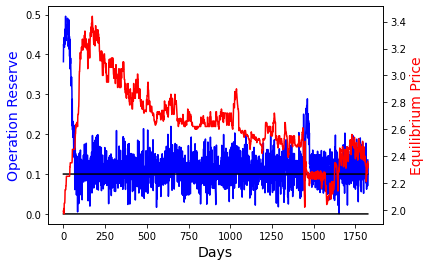

Fail rate  0.0 %


In [14]:
Draw(LOR,LORD,LEQP,N_Days)